# contents

The new way of picking the outliers: those with most absolute count (instead of percentage).

- Outlier of editors
- Outlier of journals

In [1]:
import pandas as pd

In [2]:
editors = pd.read_csv("/scratch/fl1092/capstone/elsevier/editors.csv", sep='\t',
                     usecols=["NewAuthorId", "issn", "start_year", "end_year"],
                     dtype={"NewAuthorId":int, "issn":str, "start_year":int, "end_year":int})

assert(editors.issn.apply(lambda x: len(x) ==8).all())
assert(editors[(editors.start_year >= 2018) | (editors.start_year < 1950)].shape[0]==0)

In [3]:
%%time
paper_journal = pd.read_csv("/scratch/fl1092/capstone/mag/PaperJournals.csv", sep='\t', memory_map=True,
                        usecols=['PaperId', 'JournalId'], dtype={'PaperId':int, 'JournalId':int})

paper_journal = paper_journal.rename(columns={'JournalId':'PaperJournalId'})

elsevier_journals = pd.read_csv("/scratch/fl1092/capstone/bigmem/Journals_matched.csv", sep="\t",
                               usecols=['JournalId','issn'],
                               dtype={'CitationCount':int,'DisplayName':str,'JournalId':int,
                                      'PaperCount':int,'Rank':int,'issn':str})

CPU times: user 13.3 s, sys: 5.51 s, total: 18.8 s
Wall time: 36.5 s


In [4]:
%%time
papers = pd.read_csv("/scratch/fl1092/capstone/elsevier/EditorsPaperNoEditorials.csv", sep='\t',
                    dtype={'NewAuthorId':int, 'PaperId':int, 'Year':int})
assert(papers.duplicated(subset=['NewAuthorId','PaperId']).any()==False)

papers = (
    papers.merge(editors, on='NewAuthorId')
    .merge(paper_journal, on='PaperId')
    .merge(elsevier_journals, on='issn')
)

CPU times: user 33.2 s, sys: 7.07 s, total: 40.2 s
Wall time: 1min 14s


In [5]:
papers = papers.assign(edit=papers.PaperJournalId == papers.JournalId)

papers = papers.assign(during = papers.apply(
    lambda row: (row['Year'] >= row['start_year']) & (row['Year'] <= row['end_year']) ,axis=1))

papers = papers.assign(during = papers.during & papers.edit)

In [6]:
assert( (papers[papers.during==True].edit == True).all() == True)

In [7]:
papers = papers.drop(['issn','JournalId','start_year','end_year'], axis=1).drop_duplicates()

papers = papers.sort_values(by=['edit','during'],ascending=False)
papers = papers.drop_duplicates(subset=['NewAuthorId','PaperId'], keep='first')

In [8]:
during = (
    papers[(papers.edit == True) & (papers.during==True)]
    .groupby(['NewAuthorId']).PaperId.nunique().reset_index()
    .rename(columns={'PaperId':'PaperCount'})
)
during.shape # 10327

(10327, 2)

In [9]:
total = papers.groupby('NewAuthorId').PaperId.nunique().reset_index().rename(columns={'PaperId':'Count'})
conflict = papers.groupby(['NewAuthorId','during','edit']).PaperId.nunique().reset_index().rename(
    columns={'PaperId':'Conflict'})

conflict = conflict[(conflict.during==True) & (conflict.edit==True)].drop(['during','edit'], axis=1)

conflict = conflict.merge(total, on='NewAuthorId')
print(conflict.shape) # (10327, 5)

conflict = conflict.assign(percent=conflict.Conflict/conflict.Count)

(10327, 3)


In [ ]:
conflict[conflict.Count >= 30].sort_values(by='percent', ascending=False).head(15).to_csv(
    '/scratch/fl1092/capstone/revise/extreme.csv',sep='\t',index=False)

# Plot outliers

In [10]:
import pandas as pd
import numpy as np
import scipy.stats
import math

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['grid.linewidth'] = 0.5
matplotlib.rcParams['axes.linewidth'] = 0.5
plt.rcParams["font.size"] = 7

width=0.6

In [11]:
editor_papers = pd.read_csv("/scratch/fl1092/capstone/temp/JournalOutlierEditorPapers.csv", sep='\t',
                           dtype={"issn":str,"Year":int,"Count":int})

total_papers = pd.read_csv("/scratch/fl1092/capstone/temp/JournalOutlierTotalPapers.csv", sep='\t',
                         dtype={"issn":str,"Year":int,"Total":int})

editor_papers.shape, total_papers.shape # (12553, 3), (58382, 3)

((12553, 3), (58382, 3))

In [12]:
# https://stackoverflow.com/questions/10481990/matplotlib-axis-with-two-scales-shared-origin

def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)

In [13]:
def aSum(lists):
    return [sum([l[ind] for l in lists]) for ind in range(len(lists[0]))]

In [14]:
def styleAx(ax, ax2, ytop, xleft, xright):
    ### set lim ###
    lo, hi = ax.get_ylim()
    if ytop is not None:
        hi = ytop
    left_lo = - hi * 0.2
    ax.set_ylim(left_lo, hi)
    
    ax2.set_ylim(-0.2, 1)
    
    ax.set_xlim(xleft, xright)
    ### set lim ###
    
    ### spine color ###
    ax2.spines['right'].set_color('red')
    ax2.tick_params(axis='y', colors='red')
    ### spine color ###
    
    ### control spines ###
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    
    ### control spines ###
    
    ax.set_yticks([x for x in ax.get_yticks() if x >=0 and x < hi])
    ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax2.set_yticklabels(['0', '20', '40', '60', '80', '100'])
    
    align_yaxis(ax, 0, ax2, 0)
    ax2.spines['right'].set_bounds(0, 1)
    ax.spines['left'].set_bounds(0, hi)
    
    return left_lo

In [31]:
def plotEditor(ID, ax, msg='', ytop=None, unify=False):
    # unify: whether unify y-axis across row
    ax2 = ax.twinx()   
    
    #colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072']
    colors = ['#02c6c7','#ffae01','#008b00','#ff0200']
    
    sub_papers = papers[papers.NewAuthorId == ID] # subset of papers by this editor
    bad_papers = (
        sub_papers.merge(elsevier_journals, left_on='PaperJournalId', right_on='JournalId', how='left')
        .fillna('')
    )
    # find the issn of those papers, if paper is not published in an Elseiver journal, issn is nan
    assert(sub_papers.shape[0] == bad_papers.shape[0])
    
    bad_count = bad_papers.groupby(['Year','issn','during','edit']).PaperId.nunique().reset_index()
    
    x= [year for year in range(bad_count.Year.min(), bad_count.Year.max()+1)]
    
    issn = list(bad_count[bad_count.edit==True].issn.unique())
    
    journals = [[] for i in issn]
    notj = []
    notedit = []
    
    if len(issn) == 1:
        issnlabel=["Editor's journal"]
    elif len(issn) == 2:
        issnlabel=["Editor's $1^{st}$ journal","Editor's $2^{nd}$ journal"]
    elif len(issn) == 3:
        issnlabel=["Editor's $1^{st}$ journal","Editor's $2^{nd}$ journal",
                  "Editor's $3^{rd}$ journal"]
    elif len(issn) == 4:
        issnlabel=["Editor's $1^{st}$ journal","Editor's $2^{nd}$ journal",
                   "Editor's $3^{rd}$ journal","Editor's $4^{th}$ journal"]
    else:
        print("ERROR!")
        
    highest = bad_count.groupby('Year').PaperId.sum().reset_index().PaperId.max()
    if not unify:
        ytop=highest*1.1

    for year in range(bad_count.Year.min(), bad_count.Year.max()+1):
        for ind, j in enumerate(issn):
            
            df = bad_count[(bad_count.issn == j) &
                           (bad_count.Year == year) &
                           (bad_count.during == True) &
                           (bad_count.edit == True)
                          ]
            journals[ind].append(df.PaperId.sum())
        
        df = bad_count[(bad_count.Year == year) & (bad_count.during == False) & (bad_count.edit == True)]
        notj.append(df.PaperId.sum())
        
        df = bad_count[(bad_count.Year == year) & (bad_count.edit == False)]
        notedit.append(df.PaperId.sum())
        
    assert(bad_papers.shape[0] == bad_count.PaperId.sum())
    assert(bad_papers.shape[0] == sum(aSum(journals)) + sum(notj) + sum(notedit))
        
    ax.bar(x, journals[0], width, label=issnlabel[0], color=colors[0])
    for i in range(1, len(journals)):
        ax.bar(x, journals[i], width, label=issnlabel[i], color=colors[i], bottom=aSum(journals[:i]))
        
    if sum(notj) != 0:
        ax.bar(x, notj, width, bottom=aSum(journals), color='black',
               label="Editor's journal but\nnot during editorship" )
    if sum(notedit) != 0:
        ax.bar(x, notedit, width, bottom=aSum([aSum(journals), notj]), color='grey', label='Other journals')
    
    left_lo = styleAx(ax, ax2, ytop, bad_count.Year.min()-0.5, bad_count.Year.max()+0.5)
    multiplier = 0.75
    
    for ind, j in enumerate(issn):
        row = editors[(editors.NewAuthorId == ID) & (editors.issn == j)]
        left, right = int(row.start_year), int(row.end_year)
        ax.hlines(multiplier * left_lo, left, right, color=colors[ind], linewidths=1)
        
        multiplier += 0.1
        
    steps = []
    running_sum, inj = 0, 0
    most = 0
    for i in range(len(x)):
        running_sum += aSum(journals)[i] + notj[i] + notedit[i]
        inj += aSum(journals)[i]
        steps.append(inj/running_sum)
        most = max(most, inj/running_sum)
    print("highest percentage:", most)
    
    ax2.step([i+1 for i in x], steps, color='red', lw=0.5)
    
    ax.set_ylabel('Paper count')
    
    ax.text(0.5, 0.98, f'{attri[attri.NewAuthorId == ID].Field.values[0]}, {attri[attri.NewAuthorId == ID].gender.values[0]}',
            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=9)

In [32]:
# originally, 5.main_questions/9.editor-in-chief_and_journal_level_analysis.ipynb#cartel-within-a-journal
width=0.6

def plotJournal(issn, ax, ytop, middle=False):
    ax2 = ax.twinx()   
    
    total = total_papers[total_papers.issn == issn]
    editor = editor_papers[editor_papers.issn == issn]
    
    if issn == '':
        total = total[total.Year >= 2000]
        editor = editor[editor.Year >= 2000]
    
    running_b, running_t = 0, 0
    steps=[]
    
    MAX =  min(total.Year.max()+1, 2019)
    
    for year in range(total.Year.min(), MAX):
        bottom = editor[editor.Year == year].Count.values
        if len(bottom) != 0: bottom = bottom[0]
        else: bottom=0
            
        top = total[total.Year == year].Total.values
        if len(top) != 0: top = top[0]
        else: top=0
        
        ax.bar(year, bottom, width, color='#5ac0c0', label='Paper authored by editor(s) of the journal')
        ax.bar(year, top-bottom, width, color='gray', bottom=bottom, label='Paper authored by other scientists')
        
        running_b += bottom
        running_t += top
        steps.append(running_b/running_t if top!=0 else 0)
        
    ax.legend(handles=[Patch(facecolor='#5ac0c0', label='Paper authored by editor(s) of the journal'),
                      Patch(facecolor='gray', label='Paper authored by other scientists')],
             loc='upper left')
    
    if issn == '':
        ax.set_xticks([x for x in range(math.ceil(total.Year.min()/5)*5, math.floor((MAX-1)/5)*5 + 1, 5)])
        print([x for x in range(math.ceil(total.Year.min()/5)*5, math.floor((MAX-1)/5)*5, 5)])
        
    ax2.step([year for year in range(total.Year.min(), MAX)], steps, color='red', lw=0.5)
    
    styleAx(ax, ax2, ytop, total.Year.min()-0.5, MAX-0.5)
    
    if middle:
    # ax2.set_ylabel("Proportion of papers authored by the\njournal's editor(s) out of all papers\npublished in the journal to date", c='red')
        ax2.set_ylabel("Percentage of papers authored by the journal's editor(s) out of all papers published in the journal to date", c='red')
        
    ax.set_ylabel('Paper count')

#### other attributes of editors

In [17]:
editor_gender = pd.read_csv('/scratch/fl1092/capstone/revise/EditorGender.csv',sep='\t',
                            usecols=['NewAuthorId','issn','gender'],
                            dtype={'NewAuthorId':int,'issn':str, 'start_year':int, 'end_year':int, 'gender':str})
print(editor_gender.shape)
editor_gender = editor_gender.drop_duplicates()
print(editor_gender.shape)

(15984, 3)
(15984, 3)


In [18]:
editor_gender.gender.value_counts()

male      13331
female     2653
Name: gender, dtype: int64

In [19]:
editor_gender = pd.read_csv('/scratch/fl1092/capstone/revise/EditorGender.csv',sep='\t',
                            usecols=['NewAuthorId','gender'],
                            dtype={'NewAuthorId':int,'issn':str, 'start_year':int, 'end_year':int, 'gender':str})
print(editor_gender.shape)
editor_gender = editor_gender.drop_duplicates()
print(editor_gender.shape)

editor_gender.duplicated().any()

(15984, 2)
(14476, 2)


False

In [20]:
%%time
author_career = pd.read_csv('/scratch/fl1092/capstone/conflated/AuthorEraDisp.csv',
            sep='\t', memory_map=True,
            usecols=['NewAuthorId', 'Parent'],
            dtype={'NewAuthorId':int, 'Yfp':int, 'Ylp':int, 'Parent':int})
print(author_career.shape)

(120948543, 2)
CPU times: user 18.5 s, sys: 7.14 s, total: 25.6 s
Wall time: 49.9 s


In [21]:
field_name = (
    pd.read_csv("/scratch/fl1092/capstone/advanced/FieldsOfStudy.txt", sep="\t",
                        names = ["FieldOfStudyId", "Rank", "NormalizedName", "DisplayName",
                                 "MainType", "Level", "PaperCount", "CitationCount", "CreatedDate"],
                       usecols=['FieldOfStudyId','DisplayName','Level'])
    .rename(columns={'DisplayName':'Field', 'FieldOfStudyId':'Parent'})
    .query('Level == 0')
    .drop('Level', axis=1)
)
field_name.shape

(19, 2)

In [22]:
jfield = (
    pd.read_csv("/scratch/fl1092/capstone/bigmem/Elsevier_journal_top_fields.csv", sep='\t', index_col=0)
    .merge(field_name, on='Parent')
)

In [23]:
%%time
attri = (
    conflict[conflict.Count >= 30].sort_values(by='percent', ascending=False).head(100).reset_index(drop=True)
    .reset_index()
    .merge(editor_gender, on='NewAuthorId', how='left')
    .fillna('')
    .merge(author_career, on='NewAuthorId')
    .merge(field_name, on='Parent')
    .sort_values(by='index')
)

CPU times: user 39.3 s, sys: 10.2 s, total: 49.5 s
Wall time: 1min 29s


In [25]:
import scipy

In [26]:
attri = attri.assign(gender = attri.gender.apply(lambda x: 'man' if x == 'male' else 'woman'))

highest percentage: 0.6190476190476191
highest percentage: 0.6551724137931034
highest percentage: 0.6086956521739131
highest percentage: 0.6585365853658537
highest percentage: 0.6190476190476191
highest percentage: 0.7647058823529411
highest percentage: 0.8571428571428571
highest percentage: 0.7096774193548387
highest percentage: 0.5538461538461539
highest percentage: 0.51953125
highest percentage: 0.625
highest percentage: 0.7272727272727273


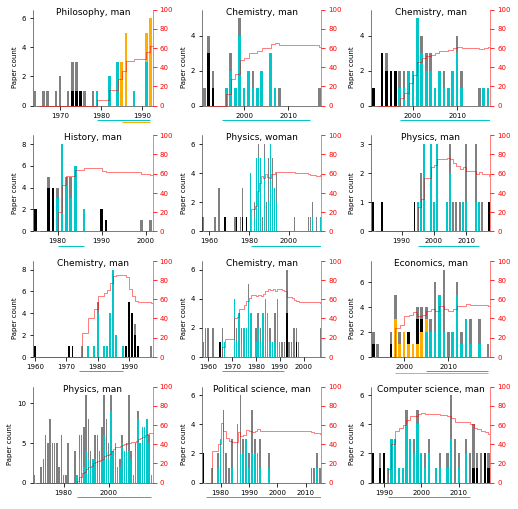

In [33]:
cm = 1/2.54
plt.figure(figsize=(18.3*cm, 18*cm))

ax = plt.subplot(4, 3, 1)
plotEditor(23259107, ax, ytop=6)

ax = plt.subplot(4, 3, 2)
plotEditor(34940835, ax, ytop=6)

ax = plt.subplot(4, 3, 3)
plotEditor(59881263, ax, ytop=6)

ax = plt.subplot(4, 3, 4)
plotEditor(3184549, ax, ytop=8)
ax.set_yticks([0, 2, 4, 6, 8])

ax = plt.subplot(4, 3, 5)
plotEditor(74697510, ax, ytop=8)

ax = plt.subplot(4, 3, 6)
plotEditor(117684713, ax, ytop=8)

ax = plt.subplot(4, 3, 7)
plotEditor(106856087, ax, ytop=8)
ax.set_yticks([0, 2, 4, 6, 8])

ax = plt.subplot(4, 3, 8)
plotEditor(127379378, ax, ytop=8)

ax = plt.subplot(4, 3, 9)
plotEditor(7182511, ax, ytop=8)

ax = plt.subplot(4, 3, 10)
plotEditor(51286327, ax, ytop=11)

ax = plt.subplot(4, 3, 11)
plotEditor(14508310, ax, ytop=11)

ax = plt.subplot(4, 3, 12)
plotEditor(23284928, ax, ytop=11)

plt.tight_layout()

plt.savefig('../figures/fig_3_revision_supp_top15.pdf', bbox_inches = 'tight', pad_inches = 0)